In [1]:
.libPaths()

[1] "/Library/Frameworks/R.framework/Versions/4.0/Resources/library"

## 1. 环境设置

In [1]:
library(R2OpenBUGS)
library(coda)
library(deSolve)
library(ggplot2)
library(lattice)

In [2]:
library(reshape2)

In [3]:
library(gganimate)
# library(chron)

In [4]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

## 2. 读取患者实际数据

In [5]:
pat_data <- read.csv(file="diabetes_case1.csv", header=T)

In [6]:
head(pat_data)

,date,time_relative,time_accu,time_in_day,Metformin,DPP_4,Glu,meal
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
1,7,0.0,8.0,8.0,500,100,0.0,130
2,7,0.5,8.5,8.5,0,0,0.0,0
3,7,3.5,11.5,11.5,500,0,0.0,130
4,7,4.0,12.0,12.0,0,0,12.6,0
5,7,9.0,17.0,17.0,0,0,0.0,130
6,7,9.5,17.5,17.5,0,0,0.0,0


In [314]:
t_obv<-pat_data$time_relative
metformin_dosing<-pat_data$Metformin
dpp4_dosing<-pat_data$DPP_4
meal_dosing<-pat_data$meal

## 3. 理论参数模型

### 3.1. 单次给药模拟

In [9]:
## 理论参数

#sitagliptin
Ka_sita <- 1.64 #(/h)
Kqf_sita<-11.1 #(L/h)
Vcf_sita<-266 #(L)
Vpf_sita<-101
CLf_sita<-39.1 #(L/h)
Emax_sita<-100 #(100% inh)
EC50_sita<-12.9 #(ng/mL)
gamma_sita<-0.823

#metformin
Ka_met<-0.41 #(/h)
V_met<-113 #(L)
CLf_met<-52.9 #(L/h)
Emax_met<-19.8 #(ug/mL? mg/dL)
EC50_met<-3.68 #(ug/mL)
tau_met<-0.5 #(h)
gamma_met<-0.55

#meal
Ktr_glu<-6.9 #(/h)
Ka_glu<-0.892 #(/h)
Vdf_glu<-19.1 #(L)
CLf_glu<-83.7 #(L/h)
base_glu<-82.9 #(mg/dL)

In [349]:
## ODE
## 间接效应PK-PD模型
PKPD <- function(t, y, parms) {
    #sitagliptin
    dx1_si_dt <- -Ka_sita*y[1] #y1 x1_si
    dx2_si_dt <- Ka_sita*y[1]-CLf_sita*y[2]/Vcf_sita- Kqf_sita*y[2]/Vcf_sita+Kqf_sita*y[3]/Vpf_sita #y2 x2_si
    dx3_si_dt <- Kqf_sita*y[2]/Vcf_sita-Kqf_sita*y[3]/Vpf_sita #y3 x3_si
    Cp_si <- y[2]*1000/Vcf_sita
    E_si <- Emax_sita*Cp_si^gamma_sita/(EC50_sita^gamma_sita+Cp_si^gamma_sita)
    
    #metformin
    dx1_met_dt <- -Ka_met*y[4] #y4 x1_met
    dx2_met_dt <- Ka_met*y[4]-CLf_met*y[5]/V_met #y[5] x2_met
    Cp_met <- y[5]/V_met
    DR_met <- Emax_met*Cp_met^gamma_met/(EC50_met^gamma_met+Cp_met^gamma_met)
    dm1_dt <- (DR_met-y[6])/tau_met #y[6] m1
    dm2_dt <- (y[6]-y[7])/tau_met #y[7] m2
    dm3_dt <- (y[7]-y[8])/tau_met #y[8] m3
    
    #glu
    dx1_glu_dt <- -Ktr_glu*y[9] #y[9] x1_glu
    dx2_glu_dt <- Ktr_glu*y[9]-Ktr_glu*y[10] #y[10] x2_glu
    dx3_glu_dt <- Ktr_glu*y[10]-Ka_glu*y[11] #y[11] x3_glu
    dx4_glu_dt <- Ka_glu*y[11]-CLf_glu*(1+E_si/100)*y[12]/Vdf_glu #y[8]*Vdf_glu*10/1000 #y[12] x4_glu (g/L)
    
    list(c(dx1_si_dt,dx2_si_dt,dx3_si_dt,dx1_met_dt,dx2_met_dt,dm1_dt,dm2_dt,dm3_dt,dx1_glu_dt,dx2_glu_dt,dx3_glu_dt,dx4_glu_dt))
  }
yini <- c(x1s=100,x2s=0,x3s=0,x1m=500,x2m=0,m1m=0,m2m=0,m3m=0,x1g=130,x2g=0,x3g=0,x4g=0) #ng/mL  base_glu*Vdf_glu*10/1000
times <- seq(from = 10, to = 24, by = 1)
out_st <- ode(times = times, y = yini, func = PKPD, parms = NULL)

In [350]:
head(out_st,n=3)

time,x1s,x2s,x3s,x1m,x2m,m1m,m2m,m3m,x1g,x2g,x3g,x4g
10,100.000000,0.00000,0.000000,500.0000,0.0000,0.000000,0.000000,0.000000,1.300000e+02,0.000000000,0.000000,0.000000
11,19.398004,71.72509,1.900139,331.8251,132.1688,5.175841,3.096146,1.494576,1.310118e-01,0.903983238,18.076645,8.952104
12,3.762826,73.62275,4.655317,220.2158,170.4733,7.108571,6.157482,4.777024,1.320436e-04,0.001822093,0.980394,0.539942


In [351]:
tail(out_st,n=3)

,time,x1s,x2s,x3s,x1m,x2m,m1m,m2m,m3m,x1g,x2g,x3g,x4g
"[13,]",22,2.849233e-07,16.76539,9.865847,3.649553,12.926349,2.793573,3.036323,3.291475,4.070881e-13,-1.444188e-11,2.467113e-11,-2.768051e-09
"[14,]",23,5.526903e-08,14.84956,9.461981,2.422025,9.058738,2.360891,2.577179,2.806625,-9.181496e-12,4.544221e-10,-7.784162e-10,1.769147e-07
"[15,]",24,1.074113e-08,13.22121,9.030412,1.607375,6.312493,1.981293,2.171146,2.374161,-6.590232e-11,2.986291e-09,-5.097997e-09,-8.884230e-07


In [352]:
out_st_df <- as.data.frame(out_st)

In [353]:
E_t_st <- ggplot(aes(x = time),data=out_st_df) +
  geom_line(aes(y = x3g,colour = "blue"),show.legend = TRUE) +
  geom_line(aes(y = x4g, colour = "green")) +
#   geom_point(aes(x = grid, y = r_score, colour = "red"), data=out_real, show.legend = TRUE) + 
#   ylab(label = "Effects_Score") +
#   xlab(label = "Time(min)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
#   transition_reveal(time)+
#   coord_cartesian(xlim = c(-10, 250)) + 
  theme_bw()

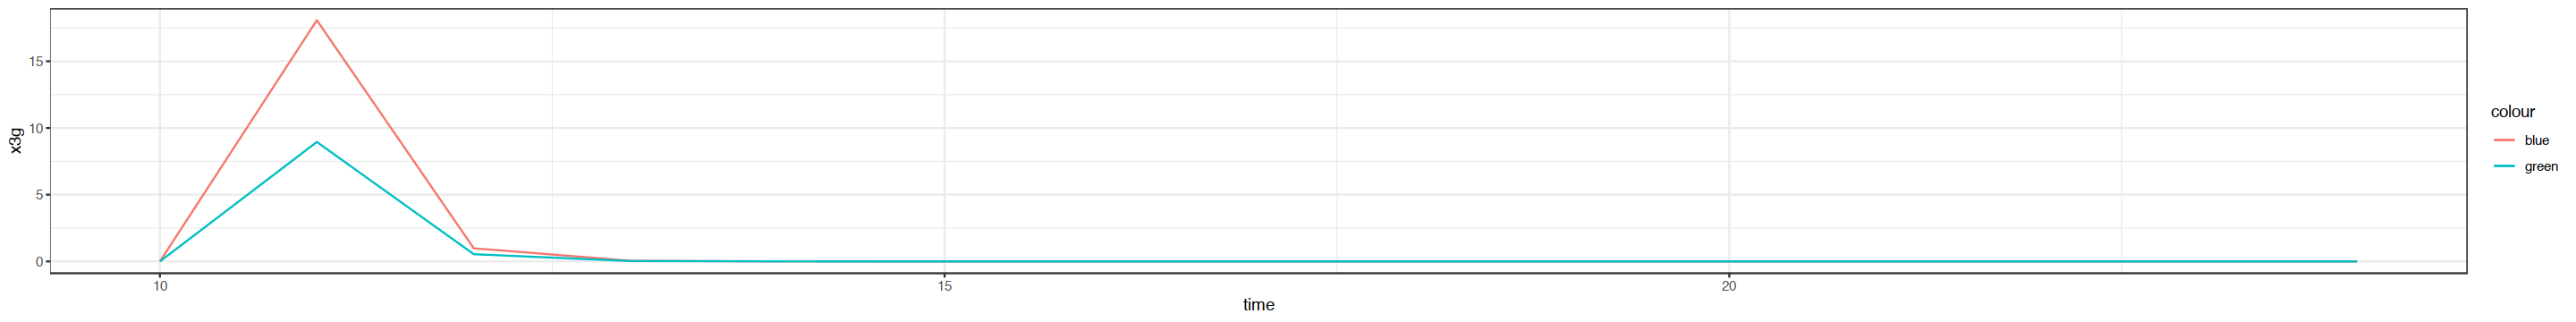

In [354]:
E_t_st

### 3.2. 多次给药模拟

In [153]:
mult_drug_dosing<-function(time_seq,metformin_seq,DPP4_seq,meal_seq){
    n=length(time_seq)-1
    
    for (i in 1:n){
        
        times <- seq(from = time_seq[i], to = time_seq[i+1], by = (time_seq[i+1]-time_seq[i])/10)
        
        if (i==1){
            
            
            yini <- c(x1s=DPP4_seq[i],x2s=0,x3s=0,x1m=metformin_seq[i],x2m=0,m1m=0,m2m=0,m3m=0,x1g=meal_seq[i],x2g=0,x3g=0,x4g=0) #ng/mL  base_glu*Vdf_glu*10/1000

            out_st <- ode(times = times, y = yini, func = PKPD, parms = NULL)
            df <- as.data.frame(out_st)
#             print(df)
        } else {
            
            yini <- out_st[dim(out_st)[1],c(2:dim(out_st)[2])]
            yini['x1s']<-yini['x1s']+DPP4_seq[i]
            yini['x1m']<-yini['x1m']+metformin_seq[i]
            yini['x1g']<-yini['x1g']+meal_seq[i]
            
            
#             print(yini)
            
            out_st <- ode(times = times, y = yini, func = PKPD, parms = NULL)
            
            temp_df <- as.data.frame(out_st)
            
            
            df<-rbind(df[0:(dim(df)[1]-1),],temp_df)
        }
    }
    return(df)
}

In [249]:
EC50_sita<-12.2

In [355]:
dftest<-mult_drug_dosing(time_seq=t_obv,metformin_seq=metformin_dosing,DPP4_seq=dpp4_dosing,meal_seq=meal_dosing)

In [357]:
dftest$x4g<-dftest$x4g-dftest$m3m*Vdf_glu*10/1000

In [210]:
dftest[dftest$time==432.0,]

,time,x1s,x2s,x3s,x1m,x2m,m1m,m2m,m3m,x1g,x2g,x3g,x4g
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1081,432,100,6.155877,6.066891,500.1385,0.6907172,0.6340298,0.7057402,0.7848357,520,-1.052885e-14,0.001068613,-0.02157555


In [212]:
pat_data[pat_data$time_relative==432.0,]

,date,time_relative,time_accu,time_in_day,Metformin,DPP_4,Glu,meal,Glu_g
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
109,25,432,440,8,500,100,7,130,4.966


In [191]:
##生成实际血糖升高值的观察数据，以备后续拟合
pat_data$Glu_g=pat_data$Glu*180*Vdf_glu/1000-100*Vdf_glu*10/1000 #(g,mmol/L->mg/L->g/L->g;)
pat_data$Glu_g[pat_data$Glu_g<0]<-0

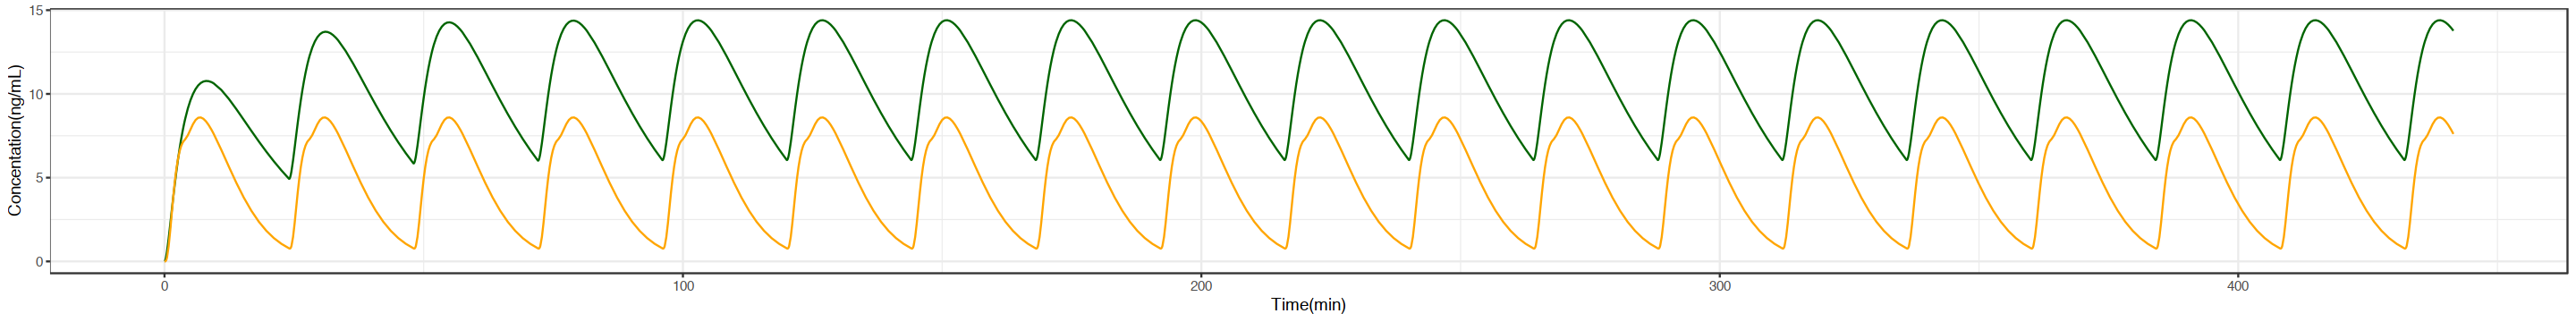

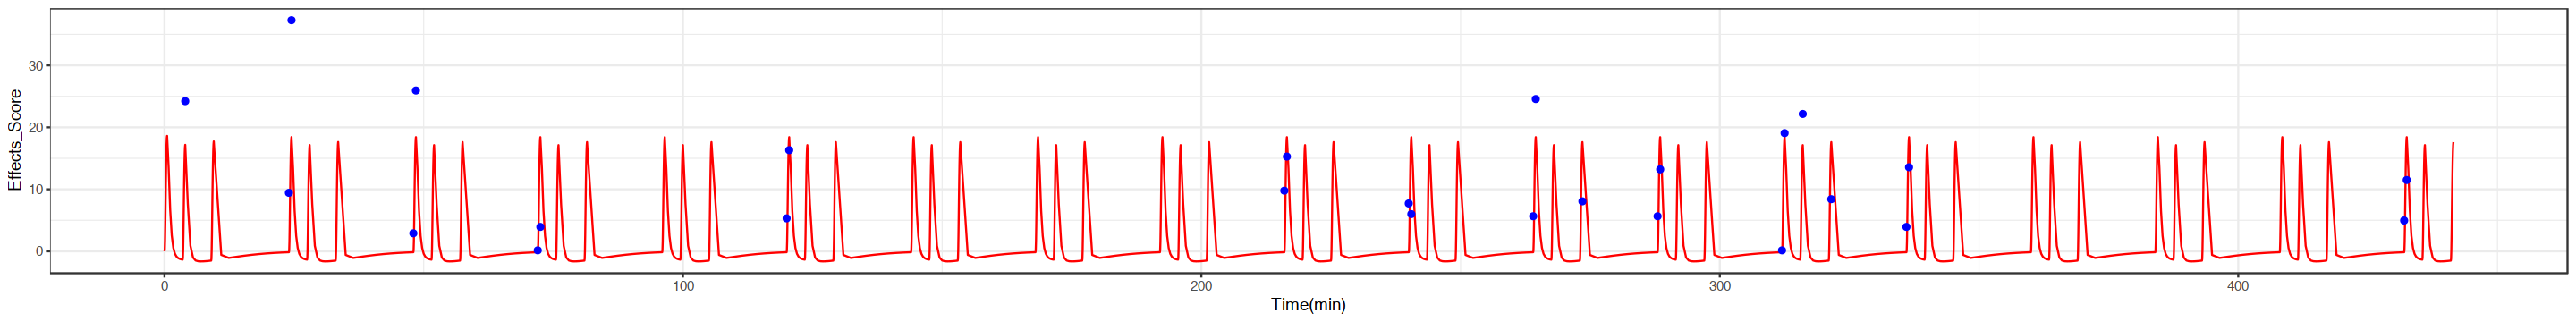

In [358]:
fig(24,3)

CpCe_trend <- ggplot(dftest,aes(x = time)) +
  geom_line(aes(y = x3s), colour = "darkgreen") +
  geom_line(aes(y = m3m), colour = "orange") +
  ylab(label = "Concentation(ng/mL)") +
  xlab(label = "Time(min)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
CpCe_trend

E_trend <- ggplot(dftest,aes(x = time)) +
  geom_line(aes(y = x4g), colour = "red") +
#   geom_line(aes(y = Ce, colour = "green")) +
  geom_point(aes(x = time_relative, y = Glu_g), pat_obs_data, colour = "blue", show.legend = FALSE) + 
  ylab(label = "Effects_Score") +
  xlab(label = "Time(min)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
E_trend

## 4. 个性化参数推导

### 4.1. MCMC建模

In [381]:
model <-    
paste(" 
model {
    
    # loop over time grid 
    for (j in 1:n.grid) {      
        equ_x[j]<-a.language[j, 12]-a.language[j, 8]*Vdf_glu*10/1000
        obs_x[j] ~ dnorm(equ_x[j] , tau.x)                           	    
    }           

    # parameters 

    #sitagliptin
    Ka_sita <- 1.64
    Kqf_sita<-11.1
    Vcf_sita<-266
    Vpf_sita<-101
    CLf_sita<-39.1
    Emax_sita<-100
    EC50_sita ~ dunif(0,24) 
    #EC50_sita<-12.9
    gamma_sita<-0.823

    #metformin
    Ka_met<-0.41
    V_met<-113
    CLf_met<-52.9
    Emax_met ~ dunif(0,40)
    #Emax_met<-19.8
    EC50_met<-3.68
    tau_met<-0.5
    gamma_met<-0.55

    #meal
    Ktr_glu<-6.9
    #Ka_glu<-0.892
    Ka_glu ~ dunif(0,10)
    Vdf_glu<-19.1
    CLf_glu<-83.7
    base_glu<-82.9

    # ODE solutions
    a.language[1:n.grid, 1:dim] <- 
        ode.block(inits[1:n.block, 1:dim], 
            grid[1:n.grid],                      
            D(C[1:dim], t),                      
            origins[1:n.block], tol)
    #sitagliptin
    D(C[1], t) <- -Ka_sita*C[1]
    D(C[2], t) <- Ka_sita*C[1]-CLf_sita*C[2]/Vcf_sita- Kqf_sita*C[2]/Vcf_sita+Kqf_sita*C[3]/Vpf_sita 
    D(C[3], t) <- Kqf_sita*C[2]/Vcf_sita-Kqf_sita*C[3]/Vpf_sita
    Cp_si <- C[2]*1000/Vcf_sita
    E_si <- Emax_sita*pow(Cp_si,gamma_sita)/(pow(EC50_sita,gamma_sita)+pow(Cp_si,gamma_sita))

    #metformin
    D(C[4], t) <- -Ka_met*C[4]
    D(C[5], t) <- Ka_met*C[4]-CLf_met*C[5]/V_met
    Cp_met <- C[5]/V_met
    DR_met <- Emax_met*pow(Cp_met,gamma_met)/(pow(EC50_met,gamma_met)+pow(Cp_met,gamma_met))
    D(C[6], t) <- (DR_met-C[6])/tau_met
    D(C[7], t) <- (C[6]-C[7])/tau_met
    D(C[8], t) <- (C[7]-C[8])/tau_met

    #glu
    D(C[9], t) <- -Ktr_glu*C[9]
    D(C[10], t) <- Ktr_glu*C[9]-Ktr_glu*C[10]
    D(C[11], t) <- Ktr_glu*C[10]-Ka_glu*C[11]
    D(C[12], t) <- Ka_glu*C[11]-CLf_glu*(1+E_si/100)*C[12]/Vdf_glu #-C[8]*Vdf_glu*10/1000


    tau.x <- 1/var.x
    var.x <- 1/(sd.x*sd.x)
    sd.x ~ dunif(0, 5)
}
")
writeLines(model,"metformin_sitagliptin_model.txt")   


### 4.2. 模型拟合个体参数

In [264]:
### prepare dosing data
pat_data$dose_sum<-pat_data$Metformin+pat_data$DPP_4+pat_data$meal

pat_dose_data<-pat_data[pat_data$dose_sum>0,c('time_relative','Metformin','DPP_4','meal')]

pat_dose_data[,c('2','3','5','6','7','8','10','11','12')]<-0

pat_dose_data<-pat_dose_data[,c('time_relative','Metformin','2','3','DPP_4','5','6','7','8','meal','10','11','12')]

In [279]:
### prepare obs data
pat_obs_data<-pat_data[pat_data$Glu_g>0,c('time_relative','Glu_g')]

In [284]:
bugs_data <- list(
    dim = 12,
    tol = 1.0E-3,

    n.grid=26,
    n.block=57,

    inits = data.matrix(pat_dose_data[,c('Metformin','2','3','DPP_4','5','6','7','8','meal','10','11','12')]),

    origins = pat_dose_data$time_relative,
    
    grid = pat_obs_data$time_relative,
    obs_x= pat_obs_data$Glu_g
)

In [302]:
init1 <- list(
  EC50_sita = runif(1, 0, 20), 
  Emax_met = runif(1, 0, 40), 
  Ka_glu = runif(1,0, 10),
#   E = runif(1, 36, 56), 
#   Emax = runif(1,700, 900),
#   gamma = runif(1,1, 15),
  sd.x = 1)
init2 <- list(
  EC50_sita = runif(1, 0, 20), 
  Emax_met = runif(1, 0, 40), 
  Ka_glu = runif(1,0, 10),
#   E = runif(1, 36, 56), 
#   Emax = runif(1,700, 900),
#   gamma = runif(1,1, 15),
  sd.x = 4)
inits <- list(init1,init2)

In [303]:
parameters <- c('EC50_sita','Emax_met','Ka_glu')

In [382]:
diabetes.sim <- bugs(
  data = bugs_data, 
  inits = inits, 
  codaPkg = TRUE,
  model.file = 'metformin_sitagliptin_model.txt', 
  parameters=parameters, 
  n.chains = 2, 
  n.iter = 2000, 
  n.burnin = 300,
  useWINE = TRUE, 
  OpenBUGS.pgm = "/Users/esther/.wine/drive_c/Program Files/OpenBUGS/OpenBUGS323/OpenBUGS.exe",
  WINE = "/Applications/Wine.app/Contents/Resources/wine/bin/wine", 
  WINEPATH = "/Applications/Wine.app/Contents/Resources/wine/bin/winepath",
  working.directory = getwd(),
  debug=TRUE)

arguments 'show.output.on.console', 'minimized' and 'invisible' are for Windows only



### 4.3. 拟合结果

In [384]:
fig(8,8)

Abstracting EC50_sita ... 1700 valid values
Abstracting Emax_met ... 1700 valid values
Abstracting Ka_glu ... 1700 valid values
Abstracting deviance ... 1700 valid values
Abstracting EC50_sita ... 1700 valid values
Abstracting Emax_met ... 1700 valid values
Abstracting Ka_glu ... 1700 valid values
Abstracting deviance ... 1700 valid values


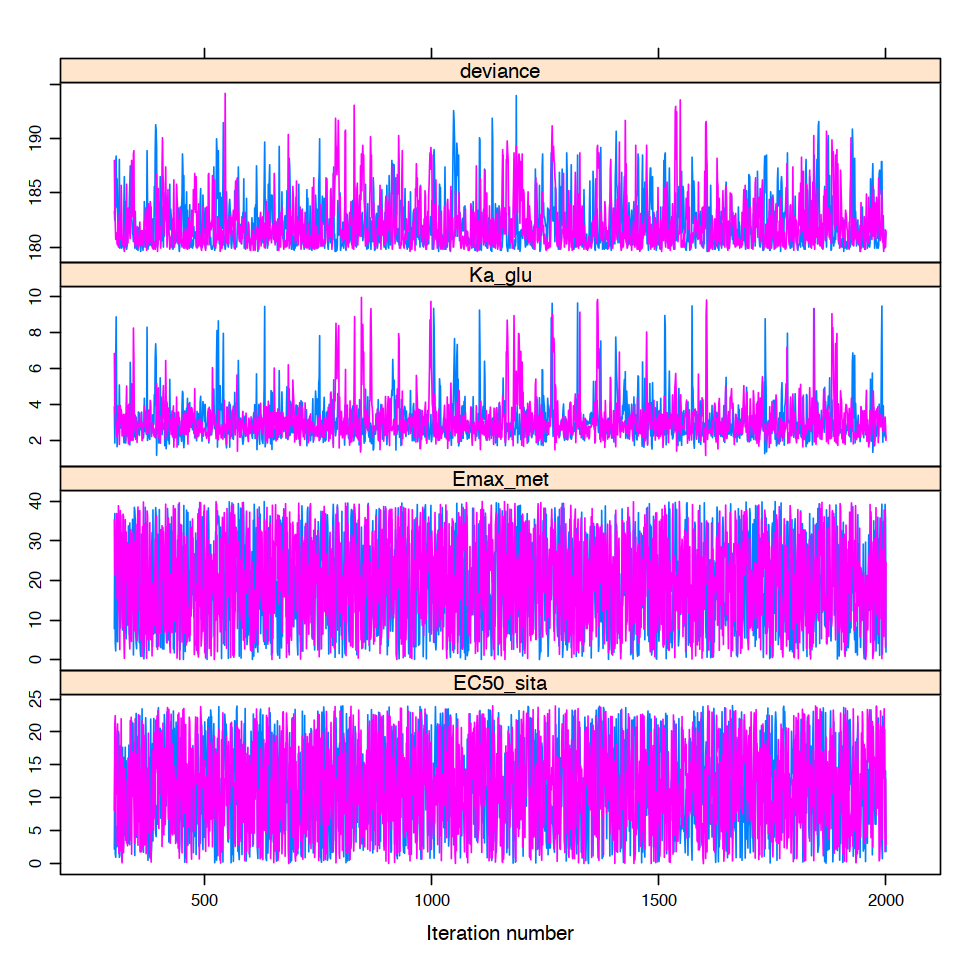

In [385]:
out.coda <- read.bugs(diabetes.sim)
xyplot(out.coda)

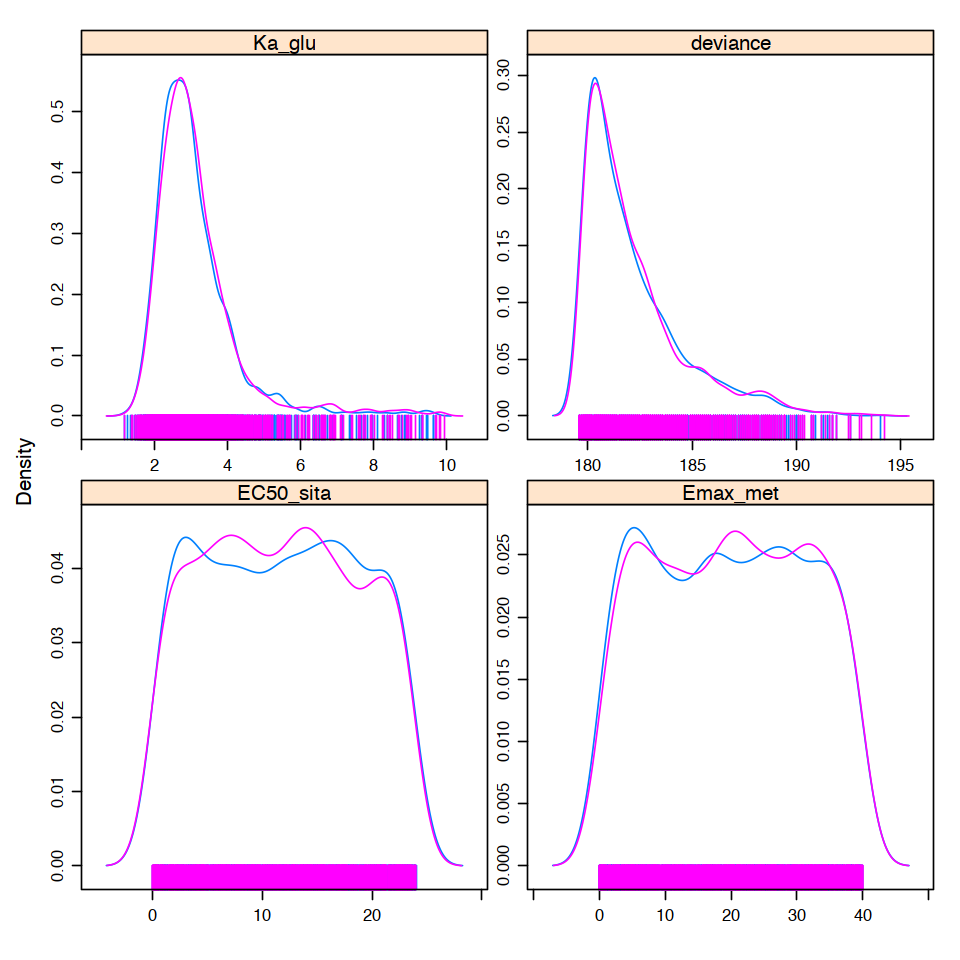

In [386]:
densityplot(out.coda) 

In [387]:
gelman.diag(out.coda) 

Potential scale reduction factors:

          Point est. Upper C.I.
EC50_sita          1       1.00
Emax_met           1       1.00
Ka_glu             1       1.01
deviance           1       1.00

Multivariate psrf

1

In [388]:
out.summary <- summary(out.coda, q = c(0.025, 0.975))
out.summary


Iterations = 301:2000
Thinning interval = 1 
Number of chains = 2 
Sample size per chain = 1700 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean     SD Naive SE Time-series SE
EC50_sita  11.790  6.898  0.11831        0.12466
Emax_met   19.776 11.573  0.19848        0.19849
Ka_glu      3.118  1.161  0.01990        0.03285
deviance  182.160  2.389  0.04097        0.07243

2. Quantiles for each variable:

              2.5%   97.5%
EC50_sita   0.5141  23.230
Emax_met    0.8441  38.930
Ka_glu      1.7820   6.621
deviance  179.8000 188.600


### 4.4. 结果验证

#### 4.4.1 更新参数

In [389]:
EC50_sita <- out.summary$statistics[,'Mean']['EC50_sita']
# K <- 0.81/60
Emax_met <- out.summary$statistics[,'Mean']['Emax_met']
# Ke0 <- 0.95/60
Ka_glu <-out.summary$statistics[,'Mean']['Ka_glu']
# Ec50 <- 600
# gamma <- 7

# yini <- c(Cp = 3000, Ce = 0)
# times <- seq(from = 0, to = 240, by = 1)


In [393]:
df_post<-mult_drug_dosing(time_seq=t_obv,metformin_seq=metformin_dosing,DPP4_seq=dpp4_dosing,meal_seq=meal_dosing)

In [394]:
df_post$x4g<-df_post$x4g-df_post$m3m*Vdf_glu*10/1000

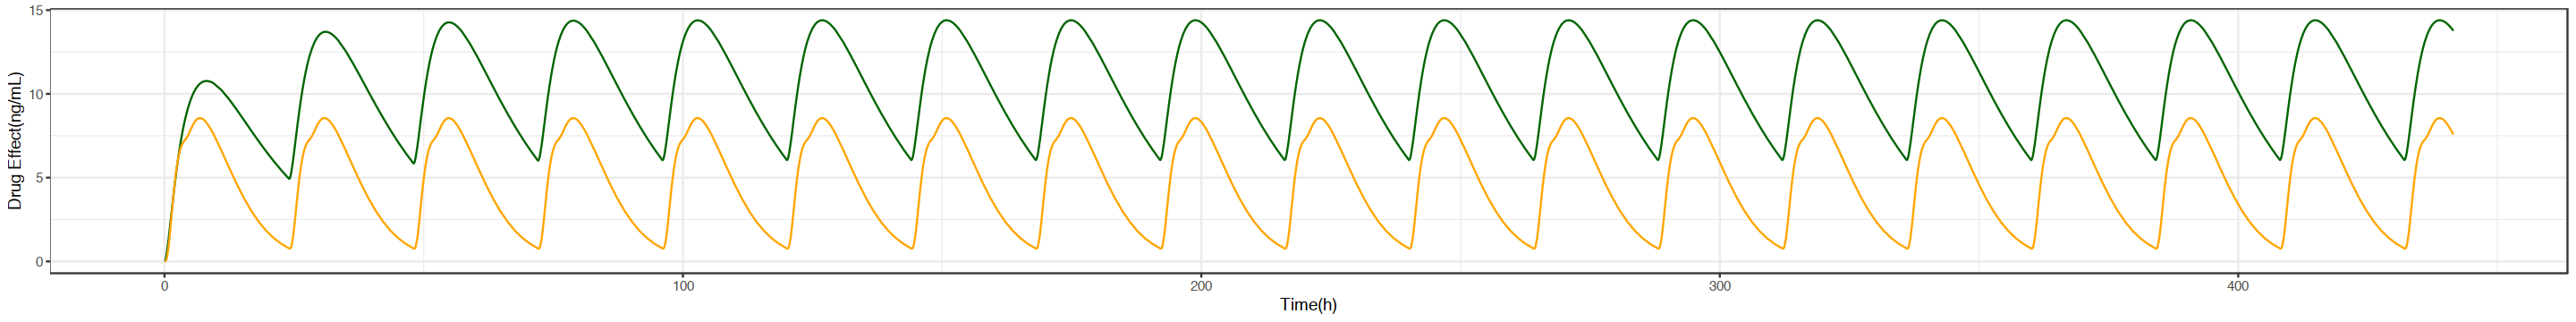

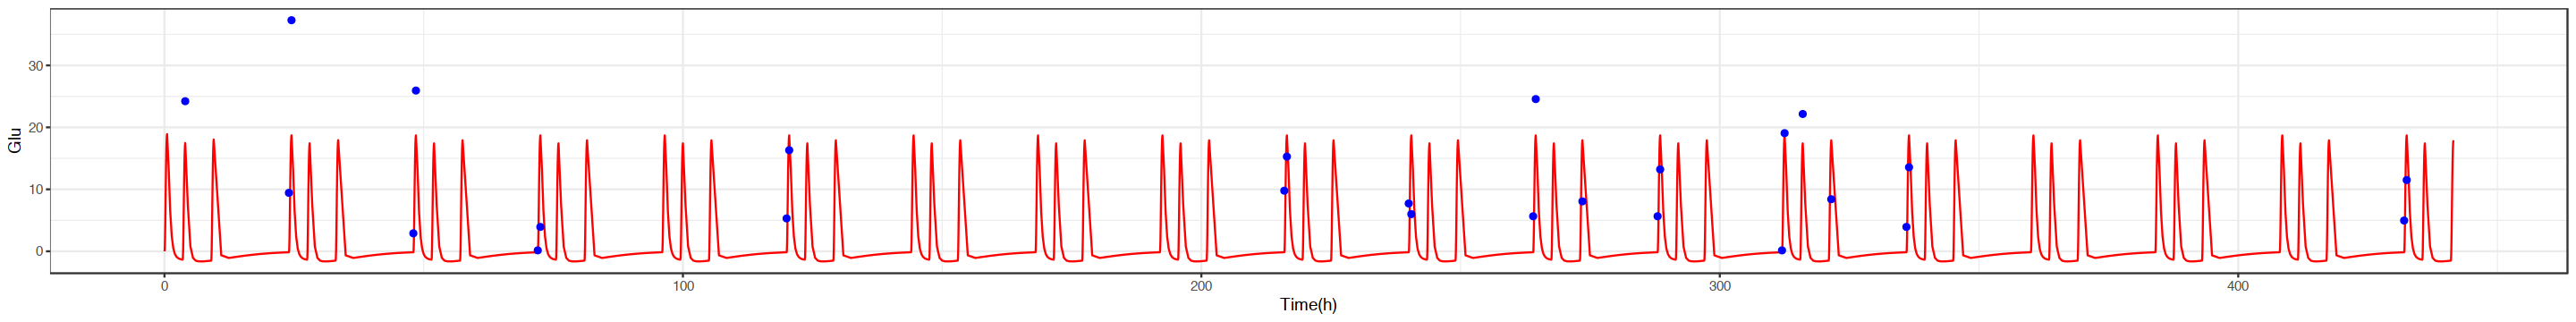

In [395]:
fig(24,3)

CpCe_trend <- ggplot(df_post,aes(x = time)) +
  geom_line(aes(y = x3s), colour = "darkgreen") +
  geom_line(aes(y = m3m), colour = "orange") +
  ylab(label = "Drug Effect(ng/mL)") +
  xlab(label = "Time(h)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
CpCe_trend

E_trend <- ggplot(df_post,aes(x = time)) +
  geom_line(aes(y = x4g), colour = "red") +
#   geom_line(aes(y = Ce, colour = "green")) +
  geom_point(aes(x = time_relative, y = Glu_g), pat_obs_data, colour = "blue", show.legend = FALSE) + 
  ylab(label = "Glu") +
  xlab(label = "Time(h)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
E_trend

### 4.5. 生成预测值

In [317]:
pat_data_pred <- read.csv(file="diabetes_case1_pred.csv", header=T)

In [318]:
head(pat_data_pred,n=3)

,date,time_relative,time_accu,time_in_day,Metformin,DPP_4,Glu,meal,tag
,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<chr>
1,7,0.0,8.0,8.0,500,100,0,130,real_data
2,7,0.5,8.5,8.5,0,0,0,0,real_data
3,7,3.5,11.5,11.5,500,0,0,130,real_data


In [319]:
t_obv_p<-pat_data_pred$time_relative
metformin_dosing_p<-pat_data_pred$Metformin
dpp4_dosing_p<-pat_data_pred$DPP_4
meal_dosing_p<-pat_data_pred$meal

In [399]:
df_pred<-mult_drug_dosing(time_seq=t_obv_p,
                          metformin_seq=metformin_dosing_p,
                          DPP4_seq=dpp4_dosing_p,
                          meal_seq=meal_dosing_p)

In [400]:
df_pred$x4g<-df_pred$x4g-df_pred$m3m*Vdf_glu*10/1000

In [401]:
tail(df_pred)

,time,x1s,x2s,x3s,x1m,x2m,m1m,m2m,m3m,x1g,x2g,x3g,x4g
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1366,537.25,2.580819e-05,27.14292,13.87315,58.60101,127.9172,7.121900,7.435550,7.722175,23.162496,39.95531,48.46532,9.271616
1367,537.30,2.377636e-05,26.96383,13.85341,57.41191,126.1330,7.088647,7.404094,7.693378,16.404151,33.95660,53.25741,12.253863
1368,537.35,2.190450e-05,26.78631,13.83341,56.24695,124.3663,7.055280,7.372462,7.664321,11.617753,28.05688,55.44067,14.674575
1369,537.40,2.018000e-05,26.61034,13.81316,55.10563,122.6171,7.021807,7.340660,7.635009,8.227929,22.70909,55.50688,16.420436
1370,537.45,1.859127e-05,26.43592,13.79265,53.98746,120.8854,6.988231,7.308694,7.605453,5.827187,18.09342,53.97282,17.481457
1371,537.50,1.712761e-05,26.26302,13.77189,52.89199,119.1714,6.954557,7.276570,7.575660,4.126931,14.23792,51.31084,17.914386


In [402]:
result<-merge(pat_data_pred,df_pred[,c('time','x4g')],by.x="time_relative",by.y="time",all.x=TRUE)

In [403]:
head(result)

,time_relative,date,time_accu,time_in_day,Metformin,DPP_4,Glu,meal,tag,x4g
,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>
1,0.0,7,8.0,8.0,500,100,0.0,130,real_data,0.000000
2,0.5,7,8.5,8.5,0,0,0.0,0,real_data,18.903601
3,3.5,7,11.5,11.5,500,0,0.0,130,real_data,-1.343360
4,4.0,7,12.0,12.0,0,0,12.6,0,real_data,17.461575
5,9.0,7,17.0,17.0,0,0,0.0,130,real_data,-1.501521
6,9.5,7,17.5,17.5,0,0,0.0,0,real_data,18.026026


In [404]:
result$pred=(result$x4g+100*Vdf_glu*10/1000)*1000/180/Vdf_glu

In [405]:
write.csv(result,file = "predit.csv",row.names = F)

In [406]:
tail(result)

,time_relative,date,time_accu,time_in_day,Metformin,DPP_4,Glu,meal,tag,x4g,pred
,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<chr>,<dbl>,<dbl>
133,528.0,29,536.0,8.0,500,100,0,130,predit,-0.1497182,5.512008
134,528.5,29,536.5,8.5,0,0,0,0,predit,18.7025677,10.995511
135,531.5,29,539.5,11.5,500,0,0,130,predit,-1.3481901,5.163412
136,532.0,29,540.0,12.0,0,0,0,0,predit,17.4180200,10.621879
137,537.0,29,545.0,17.0,0,0,0,130,predit,-1.5016174,5.118785
138,537.5,29,545.5,17.5,0,0,0,0,predit,17.9143858,10.766255


### 4.6. 模拟

#### 4.6.1. 模拟DPP-4停药

In [407]:
df_DPP4<-mult_drug_dosing(time_seq=t_obv,metformin_seq=metformin_dosing,DPP4_seq=dpp4_dosing*0,meal_seq=meal_dosing)

df_DPP4$x4g<-df_DPP4$x4g-df_DPP4$m3m*Vdf_glu*10/1000

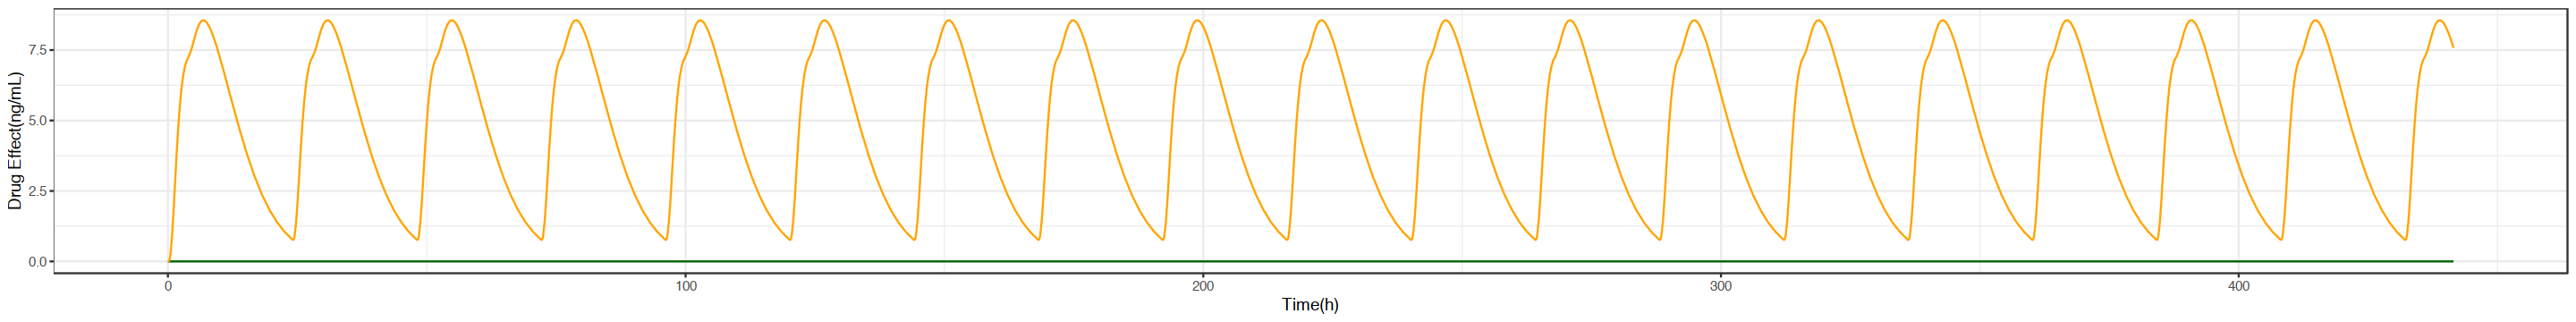

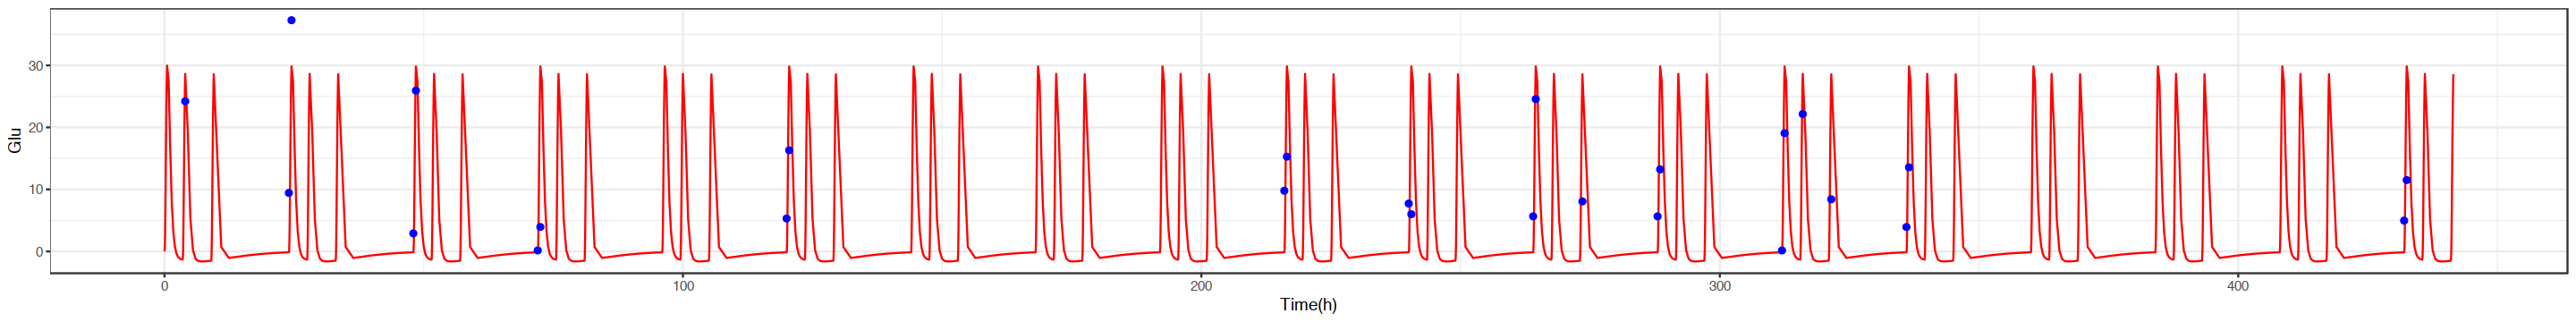

In [408]:
fig(24,3)

CpCe_trend <- ggplot(df_DPP4,aes(x = time)) +
  geom_line(aes(y = x3s), colour = "darkgreen") +
  geom_line(aes(y = m3m), colour = "orange") +
  ylab(label = "Drug Effect(ng/mL)") +
  xlab(label = "Time(h)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
CpCe_trend

E_trend <- ggplot(df_DPP4,aes(x = time)) +
  geom_line(aes(y = x4g), colour = "red") +
#   geom_line(aes(y = Ce, colour = "green")) +
  geom_point(aes(x = time_relative, y = Glu_g), pat_obs_data, colour = "blue", show.legend = FALSE) + 
  ylab(label = "Glu") +
  xlab(label = "Time(h)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
E_trend

#### 4.6.2. 模拟Metformin停药

In [409]:
df_DPP4<-mult_drug_dosing(time_seq=t_obv,metformin_seq=metformin_dosing*0,DPP4_seq=dpp4_dosing,meal_seq=meal_dosing)

df_DPP4$x4g<-df_DPP4$x4g-df_DPP4$m3m*Vdf_glu*10/1000

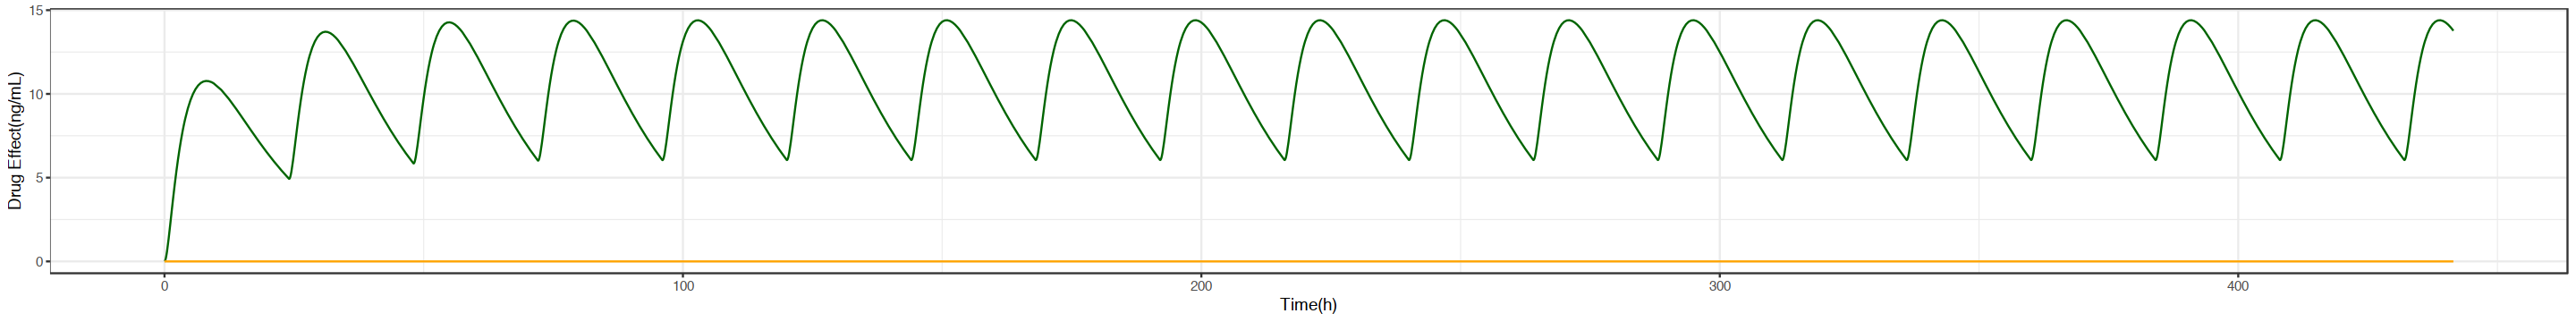

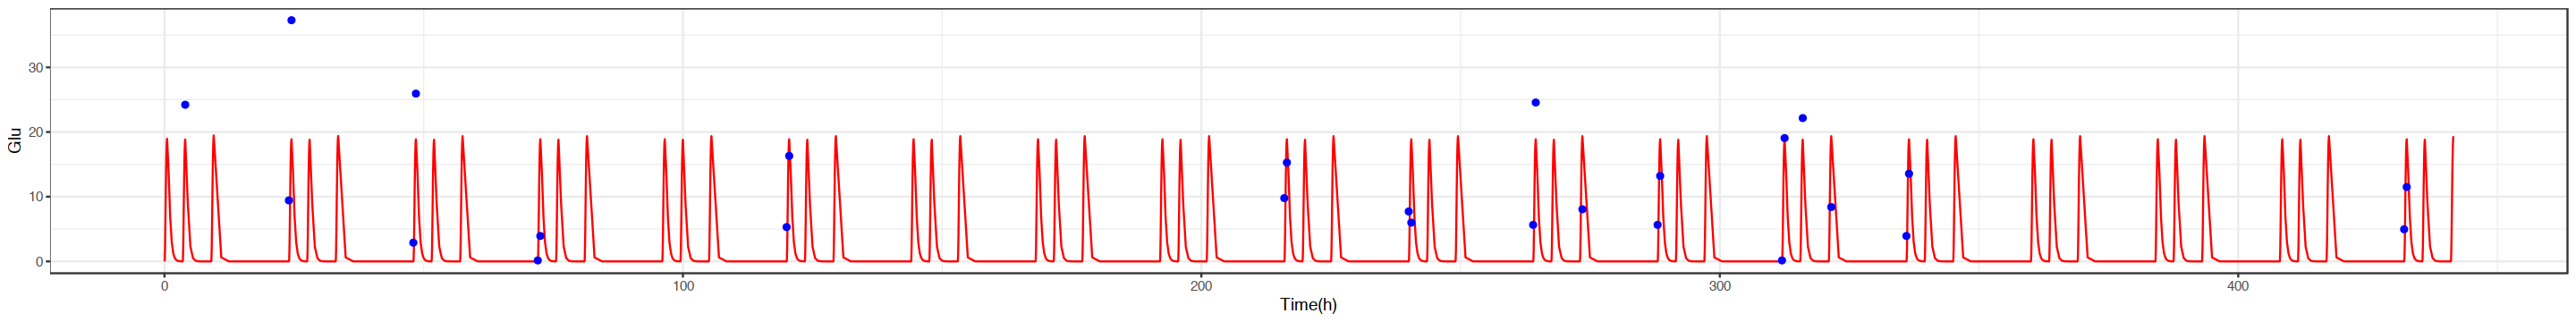

In [410]:
fig(24,3)

CpCe_trend <- ggplot(df_DPP4,aes(x = time)) +
  geom_line(aes(y = x3s), colour = "darkgreen") +
  geom_line(aes(y = m3m), colour = "orange") +
  ylab(label = "Drug Effect(ng/mL)") +
  xlab(label = "Time(h)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
CpCe_trend

E_trend <- ggplot(df_DPP4,aes(x = time)) +
  geom_line(aes(y = x4g), colour = "red") +
#   geom_line(aes(y = Ce, colour = "green")) +
  geom_point(aes(x = time_relative, y = Glu_g), pat_obs_data, colour = "blue", show.legend = FALSE) + 
  ylab(label = "Glu") +
  xlab(label = "Time(h)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
E_trend

#### 4.6.3. 模拟Metformin+DPP4停药

In [414]:
df_DPP4<-mult_drug_dosing(time_seq=t_obv,metformin_seq=metformin_dosing*0,DPP4_seq=dpp4_dosing*0,meal_seq=meal_dosing)

In [415]:
df_DPP4$x4g<-df_DPP4$x4g-df_DPP4$m3m*Vdf_glu*10/1000

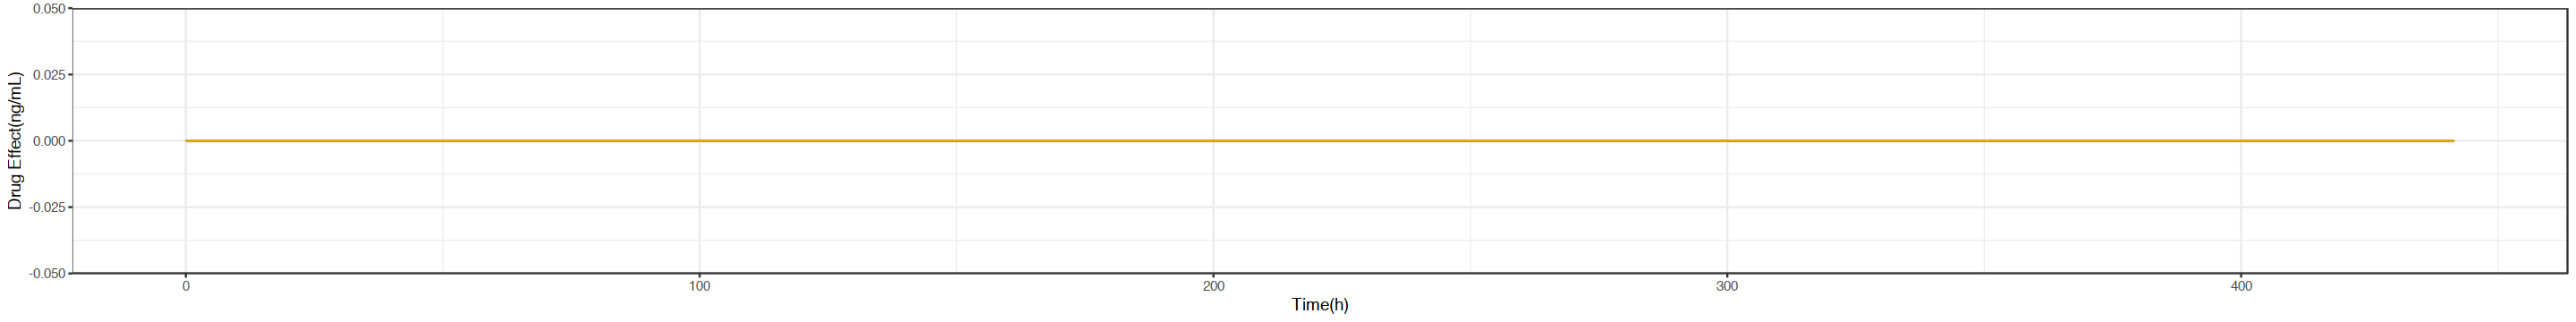

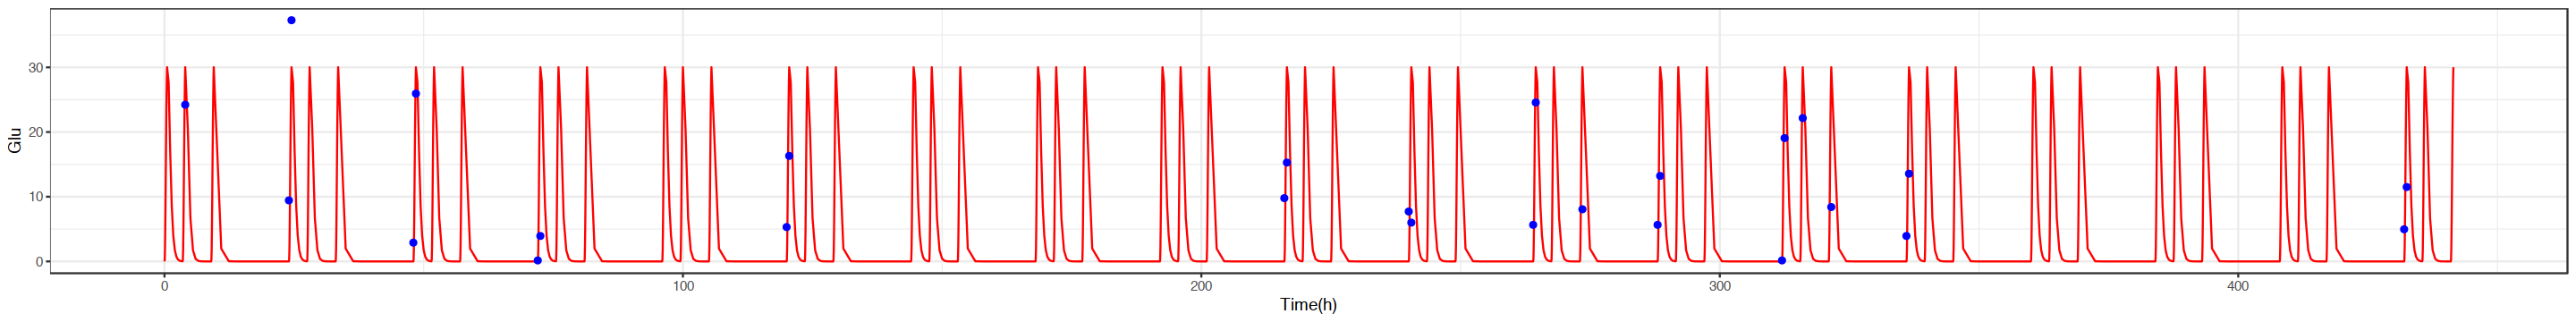

In [416]:
fig(24,3)

CpCe_trend <- ggplot(df_DPP4,aes(x = time)) +
  geom_line(aes(y = x3s), colour = "darkgreen") +
  geom_line(aes(y = m3m), colour = "orange") +
  ylab(label = "Drug Effect(ng/mL)") +
  xlab(label = "Time(h)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
CpCe_trend

E_trend <- ggplot(df_DPP4,aes(x = time)) +
  geom_line(aes(y = x4g), colour = "red") +
#   geom_line(aes(y = Ce, colour = "green")) +
  geom_point(aes(x = time_relative, y = Glu_g), pat_obs_data, colour = "blue", show.legend = FALSE) + 
  ylab(label = "Glu") +
  xlab(label = "Time(h)") +
#   scale_colour_manual(name = "Effects",
#                       labels = c("Pop", "Ind"),
#                       values = c("red", "blue")) + 
  theme_bw()
E_trend